## 1. Configurações iniciais, importação e organização das imagens que serão usadas para o treinamento

### 1.1. Importação das bibliotecas

In [1]:
# Interage com o sistema operacional, como manipular arquivos e diretórios.
import os
import sys

# Criação de strings em base64
import base64

# Geração de números aleatórios
import random

# Funções matemáticas
import math

# Extração de conteúdos em textos
import re

# Contagem de tempo
import time

# Manipulações e tratamentos de arquivos json
import json

# Manipulação de arquivos e pastas no sistema
import shutil

# Realiza computação numérica eficiente com arrays multidimensionais e funções matemáticas avançadas.
import numpy as np

# Tratamento e manipulações de dataframes
import pandas as pd

# Geração de gráficos
import matplotlib.pyplot as plt

# Tratamento de imagens
from PIL import Image, ImageOps

# Criação de redes neurais
import tensorflow

# Apresentação do progresso do código
from tqdm import tqdm

# Divisão entre dados de treino e de validação
from sklearn.model_selection import train_test_split

# Manipulações e tratamentos de imagens
import cv2

import skimage.draw
from skimage.io import imread
#import skimage

# Importa todas as funções auxiliares
from auxiliar import *

### 1.2. Funções auxiliares

In [2]:
def github_para_colab(links_github: list, pasta_saida: int) -> None:

  """
  Baixa o conteúdo dos links do GitHub para o Google Colab
  """

  # Deleta a pasta de saída caso ela já exista
  if os.path.exists(pasta_saida): shutil.rmtree(pasta_saida)

  # Cria a pasta
  os.mkdir(pasta_saida)

  # Converte eles para um foramto baixável
  links_github = list(map(github_to_raw, links_github))

  # Percorre todos os dataframes
  for link in links_github:

    # Define o caminho onde o arquivo será baixado, além do nome do próprio arquivo
    caminho_destino = os.path.join(pasta_saida, os.path.split(link)[1])

    # Cria o comando de baixar o arquivo do repositório do GitHub
    comando = f"wget -O {caminho_destino} {link}"

    # Executa o comando de baixar o arquivo do repositório do GitHub
    !{comando}

## 2. Importação do Mask-RCNN e carregamento do conjunto de dados

### 2.1. Baixa o Mask-RCNN, caso ele não esteja no diretório atual

In [3]:
# Caso Mask_RCNN-TF2 não esteja na pasta, baixa ele do repositório do GitHub
if ("Mask_RCNN-TF2" not in os.listdir()) and ("Mask_RCNN_TF2" not in os.listdir()):
    !git clone https://github.com/alsombra/Mask_RCNN-TF2

# Apresenta um abiso ao usuário
else: print("A pasta já existe, por isso não vai precisar baixá-la.")

A pasta já existe, por isso não vai precisar baixá-la.


### 2.2. Renomeia a pasta do Mask-RCNN, caso o nome esteja errado

Você precisa renomear a pasta de `Mask_RCNN-TF2` para `Mask_RCNN_TF2` para que a importação das bibliotecas funcione

In [4]:
if not os.path.exists(path = "Mask_RCNN_TF2"):

    # Tenta renomear a pasta
    try: os.rename(src = "Mask_RCNN-TF2", dst = "Mask_RCNN_TF2")

    # Avisa para o usuário renomear a pasta manualmente
    except: print("Você precisa renomear a pasta manualmente.")

else: print("A pasta já existe e já está com o nome correto.")

A pasta já existe e já está com o nome correto.


### 2.3. Instala o Mask-RCNN, caso ainda não tenha sido instalado

In [5]:
# Caminhos que são gerados após a instalação do Mask-RCNN
caminhos = [
    r"Mask_RCNN_TF2\build",
    r"Mask_RCNN_TF2\dist",
    r"Mask_RCNN_TF2\mask_rcnn.egg-info"
]

# Variável que contará quantas pastas de 'caminhos' existem
somador = 0

# Percorre todos as pastas da lista 'caminhos'
for caminho in caminhos:

    # Caso a pasta exista
    if os.path.exists(path = caminho):

        # 'somador' recebe mais um
        somador += 1

if somador == len(caminhos): print("Mask-RCNN já foi instalado.")

elif somador == 0: 
    print("Mask-RCNN não foi instalado, instalando agora.")

    # Instala o Mask-RCNN
    !cd Mask_RCNN_TF2/ && python setup.py install

else: print("Nem todas as pastas do Mask-RCNN foram instaladas")

Mask-RCNN já foi instalado.


### 2.4. Importação das bibliotecas do Mask-RCNN

``Substitua em Mask_RCNN_TF2/mrcnn/visualize.py, esse trecho de código abaixo.``

<br>

```python
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
```

<br>

``Por esse.``

<br>

```python
# Obtém o diretório onde visualize.py está localizado
ROOT_DIR = os.path.dirname(os.path.abspath(__file__))

# Adiciona o diretório `mrcnn` ao sys.path
sys.path.append(ROOT_DIR)

import utils
```

---

``Substitua em Mask_RCNN_TF2/mrcnn/model.py, esse trecho de código abaixo.``

<br>

```python
from mrcnn import utils
```

<br>

``Por esse.``

<br>

```python
import utils
```

In [6]:
# Importa as bibliotecas do MR-CNN
from Mask_RCNN_TF2.mrcnn.config import Config
import Mask_RCNN_TF2.mrcnn.utils as utils
from Mask_RCNN_TF2.mrcnn import visualize
import Mask_RCNN_TF2.mrcnn.model as modellib
from Mask_RCNN_TF2.mrcnn.model import log

### 2.5. Criação da classe

In [7]:
# ESSA FUNÇÃO CONSIDERA CADA OBJETO DENTRO DE UMA IMAGEM

class DatasetPersonalizado(utils.Dataset):

    def load_object(self, dataset_dir, subset, nome_annotation="via_region_data.json"):

        """
        Carrega um subconjunto do dataset Balloon.
        dataset_dir: Diretorio raíz do dataset.
        subset: Subconjunto a ser carregado: train (treinamento) ou val (validação)

        EXEMPLO:

        self.add_class("objetos", 1, "Balloon")
        self.add_class("objetos", 2, "Mobile phone")
        self.add_class("objetos", 3, "Ruler")

        dicionario_classe_id = {"Balloon": 1, "Mobile phone": 2, "Ruler": 3}
        dicionario_id_classe = {valor: chave for chave, valor in dicionario_classe_id.items()}
        """

        #==================================================================================================================================================

        self.add_class("objetos", 1, "Mobile phone")

        dicionario_classe_id = {"Mobile phone": 1}
        dicionario_id_classe = {valor: chave for chave, valor in dicionario_classe_id.items()}

        #==================================================================================================================================================

        # Escolhe se é o dataset de Treinamento ou Validação
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, nome_annotation)))
        annotations = list(annotations.values())  # não precisa das dict keys

        # A ferramenta VIA salva as imagens em JSON mesmo que elas não contenham nenhuma anotação. Então, pulamos as imagens não anotadas.
        annotations = [a for a in annotations if a['regions']]

        contagem = 0
        # Adiciona as imagens
        for a in annotations:
            # Pega as coordenadas x e y dos pontos dos poligonos que formam o contorno de cada instância do objeto.
            # Eles são armazenadas em shape_attributes (para visualizar, abra o arquivo json)
            # A condição if é necessária para que o código suporte anotações geradas pelas versões 1.x e 2.x da VIA.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # Caso seja uma lista
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                classe = [dicionario_classe_id[r['region_attributes']['label']] for r in a['regions']]

            # A função load_mask() vai precisar do tamanho da imagem para que possa converter os polígonos em mascaras.
            # Infelizmente, o VIA não inclui isso no JSON, então devemos ler a imagem manualmente e gerar essas máscaras.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            contagem = contagem+1

            self.add_image("objetos",
                image_id=a['filename'],  # usa o nome do arquivo como id unico da imagem
                path=image_path,
                classe = classe,
                width=width, height=height,
                polygons=polygons)

        print("Imagens "+subset+": " + str(contagem))

    def load_mask(self, image_id):
        """Gera as mascaras das instâncias para a imagem.
       Returna:
        masks: Uma array booleana de formato/shape [height, width, instance count] com 1 mascara por instancia.
        class_ids: uma array de 1D contendo os IDs das mascaras das instancias.
        """
        # Se não for uma imagem de conjunto de dados do balão (balloon dataset), delegue à classe ascendente.
        image_info = self.image_info[image_id]
        #print(image_info)
        if image_info["source"] != "objetos":
            return super(self.__class__, self).load_mask(image_id)

        # Converte os poligonos em uma mascara bitmap com shape  [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        # Agora será calculado a máscara da instância. para cada pixel da imagem, classificará como pertencente à classe ou não
        for i, p in enumerate(info["polygons"]):
            # Pega os indices dos pixels dentro dos poligonos e define eles como = 1 (cor branca), caso contrário continuará valor 0 (cor preta)
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'], mask.shape) # passamos o .shape também como 3ª parâmetro para evitar possíveis erros

            mask[rr, cc, i] = 1

        # Retorna a mascara e a array dos IDs das classes de cada instancia.
        # Como nesse exemplo temos uma classe apenas, retornamos uma array composta de 1s
        # return mask.astype(bool), np.ones([mask.shape[-1]], dtype=np.int32)
        return mask.astype(bool), (np.array(info['classe'], dtype=np.int32)).ravel()

    def image_reference(self, image_id):
        """Retorna o caminho da imagem."""
        info = self.image_info[image_id]
        if info["source"] == "objetos":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

## 3. Configuração do modelo

### 3.1. Atualização de compatibilidade

In [8]:
# Execute as 5 linhas abaixo para que não tenhamos problemas ao executar com as versões mais recentes do Tensorflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### 3.2. Configurações da rede neural

In [9]:
class ConfigRede(Config):

  # balloon_phone_ruler
  NAME = 'phone'

  # 2
  IMAGES_PER_GPU = 2

  # 1 + (quantidade de classes), visto que o fundo da imagem também será considerado
  NUM_CLASSES = 1 + 1

  # Quantidade de imagens totais de treinamento
  # quantidade_imagens_train = len(lista_image_path_train)
  quantidade_imagens_train = 800
  STEPS_PER_EPOCH = (quantidade_imagens_train // IMAGES_PER_GPU) # (Quantidade de imagens) / IMAGES_PER_GPU = 5272 / 2 = 1318
  DETECTION_MIN_CONFIDENCE = 0.9
  USE_MINI_MASK = False

  # Recomendado deixar o tamanho 512 para execuções no Colab
  IMAGE_MIN_DIM = 512 # 512
  IMAGE_MAX_DIM = 512 # 512

  # Quantidade de imagens totais de validação
  # quantidade_imagens_val = len(lista_image_path_val)
  quantidade_imagens_val = 200
  VALIDATION_STEPS = (quantidade_imagens_val // IMAGES_PER_GPU) # 5 # (Quantidade de imagens) / IMAGES_PER_GPU = 1810 / 2 = 452

### 3.3. Configurações da rede neural para inferência

In [10]:
class InferenceConfig(ConfigRede):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

### 3.4. Criação de funções auxiliares

In [11]:
def carrega_modelo_teste(model_path: str):

  """
  Retorna um modelo e suas configurações com base nos pesos referenciados.
  """

  inference_config = InferenceConfig()
  model = modellib.MaskRCNN(mode = 'inference', config = inference_config, model_dir = model_path)
  model.load_weights(model_path, by_name = True)
  return model, inference_config

In [12]:
def segmentar_imagem(model, img, tipo_modelo, visualizar: bool = False):

  resultados = model.detect([img], verbose = 0)
  r = resultados[0]

  # Define as classes que serão segmentadas
  lista_classes = ['Background']
  lista_classes.extend(tipo_modelo)

  #===============================================================================================================================

  # Apresenta a imagem original com a máscara de segmentação nos objetos identificados
  if visualizar: visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], lista_classes, r['scores'], figsize=(12,10))

  return r

## 4. Importação dos pesos do modelo já treinados do GitHub

### 4.1. Importação da branch principal e apresenta todas as branches

In [13]:
# Define se os pesos serão obtidos via GitHub
IMPORTAR_DO_GITHUB = False

# Link do repositório do GitHub
link_github = 'https://github.com/AriBarrosFilho/Pesos_Segmentation_Balloon_Phone.git'

# Pasta do Google Colab que receberá o conteúdo do repositório (A pasta será criada caso não exista)
pasta_destino = 'pesos_treinados'

#===============================================================================

# Caso o usuário tenha decidido importar os pesos do GitHub
if IMPORTAR_DO_GITHUB:

  # Caso a pasta exista, deleta ela
  if os.path.exists(pasta_destino): shutil.rmtree(pasta_destino)

  # Cria o comando de clonar a branch main do repositório para uma pasta do Google Colab
  comando = f"git clone --single-branch --branch main {link_github} {pasta_destino}"

  # Executa o comando de clonar a branch main do repositório para uma pasta do Google Colab
  !{comando}

  #-----------------------------------------------------------------------------------------------------------------------------------

  # Obtém o texto do arquivo "nome_das_branches.txt"
  with open(os.path.join(pasta_destino, "nome_das_branchs.txt")) as f:
    conteudo = f.read()

  # Cria uma lista com o nome das branches
  lista_branches = conteudo.splitlines()

  # Destaca as branches que serão apresentada abaixo
  print("\n", "-" * 100, "\n", sep = "")

  # Apresenta todas as branches do repositório
  for i, branch in enumerate(lista_branches): print(i, branch)

### 4.2. Importação de branches específicas (Que contém pesos específicos)

In [14]:
# Define quais branches serão importadas através de suas posições na lista
branches = [3, 4]

#===============================================================================

# Caso o usuário tenha decidido importar os pesos do GitHub
if IMPORTAR_DO_GITHUB:

  # Percorre cada branch definida para ser baixada
  for branch in branches:

    # Pasta do Google Colab que receberá o conteúdo do repositório
    pasta_destino_branch = os.path.join(pasta_destino, lista_branches[branch])

    # Caso a pasta exista, deleta ela
    if os.path.exists(pasta_destino_branch): shutil.rmtree(pasta_destino_branch)

    # Cria o comando de clonar a branch main do repositório para uma pasta do Google Colab
    comando = f"git clone --branch {lista_branches[branch]} --single-branch {link_github} {pasta_destino_branch}"

    # Executa o comando de clonar a branch main do repositório para uma pasta do Google Colab
    !{comando}

### 4.3. Recria os arquivos originais dos pesos com base nos dataframes

In [15]:
# Caso o usuário tenha decidido importar os pesos do GitHub
if IMPORTAR_DO_GITHUB:

  # Percorre cada branch definida para ser baixada
  for branch in tqdm(branches):

    # Pasta do Google Colab que receberá o conteúdo do repositório
    pasta_destino_branch = os.path.join(pasta_destino, lista_branches[branch])

    # Cria o caminho absoluto de onde estão os dataframes com strings em base64
    caminho_completo = os.path.abspath(os.path.join(pasta_destino_branch, lista_branches[branch]))

    #===============================================================================

    # Junta e concatena em um único dataframe todos os dataframes
    df_base64 = read_and_concat_parquets(caminho_completo)

    # Com base em um dataframe com strings em base64, converte o arquivo para o seu formato original
    combine_base64_and_restore(df = df_base64, output_directory = pasta_destino_branch)

### 4.4. Obtém o caminho completo de todos os pesos

In [16]:
# Caso o usuário tenha decidido importar os pesos do GitHub
if IMPORTAR_DO_GITHUB:

  # Lista que conterá o caminho absoluto de todos os arquivos possuem a extensão .h5, dentro de uma pasta
  lista_caminho_pesos = []

  # Percorre toda a pasta e suas subpastas
  for caminho, _, arquivos in os.walk(pasta_destino):
    for arquivo in arquivos:

      # Adiciona o caminho absoluto de todos os arquivos na lista
      lista_caminho_pesos.append(os.path.abspath(os.path.join(caminho, arquivo)))

  # Realiza uma filtragem para apenas arquivos que possuem a extensão .h5
  lista_caminho_pesos = list(filter(lambda arquivo: arquivo.endswith('.h5'), lista_caminho_pesos))

  # Aviso ao usuário
  print('Abaixo está os caminhos dos pesos disponíveis, selecione o que você deseja.', '\n', '-' * 100, '\n')

  # Apresenta o caminho completo para cada peso importado.
  for caminho in lista_caminho_pesos: print(caminho)

## 5. Carregamento das redes neurais

### 5.1. Modelo do celular

In [17]:
# Caminho onde estão os pesos treinados
caminho_pesos_treinados = "pesos_treinados_local\mask_rcnn_mobilephone_0017.h5"

#=====================================================================================================

# Tenta carregar o modelo
try:

  # Carrega o modelo com base nos pesos importados
  model_phone, inference_config_phone = carrega_modelo_teste(model_path = caminho_pesos_treinados)

# Caso não seja possível carregar o modelo
except:

  # Alerta ao usuário de que houve um problema
  print("DEU ALGO ERRADO, REVEJA AS CONFIGURAÇÕES DA QUANTIDADE DE CLASSES NA SEÇÃO 3.2.")
  model_phone, inference_config_phone = (0, 0)

Instructions for updating:
Use fn_output_signature instead


### 5.2. Modelo do balão

In [18]:
# Caminho onde estão os pesos treinados
caminho_pesos_treinados = "pesos_treinados_local\mask_rcnn_balloon_0017.h5"

# Tenta carregar o modelo
try:

  # Carrega o modelo com base nos pesos importados
  model_balloon, inference_config_balloon = carrega_modelo_teste(model_path = caminho_pesos_treinados)

# Caso não seja possível carregar o modelo
except:

  # Alerta ao usuário de que houve um problema
  print("DEU ALGO ERRADO, REVEJA AS CONFIGURAÇÕES DA QUANTIDADE DE CLASSES NA SEÇÃO 3.2.")
  model_balloon, inference_config_balloon = (0, 0)

### 5.3. Modelo do celular e do balão

In [19]:
# Caminho onde estão os pesos treinados
caminho_pesos_treinados = "NÃO VOU USAR"

# Tenta carregar o modelo
try:

  # Carrega o modelo com base nos pesos importados
  model_balloon_phone, inference_config_balloon_phone = carrega_modelo_teste(model_path = caminho_pesos_treinados)

# Caso não seja possível carregar o modelo
except:
  
  # Alerta ao usuário de que houve um problema
  print("DEU ALGO ERRADO, REVEJA AS CONFIGURAÇÕES DA QUANTIDADE DE CLASSES NA SEÇÃO 3.2.")
  model_balloon_phone, inference_config_balloon_phone = (0,0)

DEU ALGO ERRADO, REVEJA AS CONFIGURAÇÕES DA QUANTIDADE DE CLASSES NA SEÇÃO 3.2.


### 5.4. Criação do dicionário selecionador de modelos de classes

In [20]:
# Dicionário que conterá o modelo e o nome das classes para a segmentação
modelo_classe = {'balloon': (model_balloon, ['Bexiga']), 
                 'phone': (model_phone, ["Celular"]), 
                 'balloon_phone': (model_balloon_phone, ['Bexiga', 'Celular'])}

id_classe = {'1': 'Bexiga', '2': 'Celular'}

## 6. Importação das imagens a partir GitHub

### 6.1. Importação da branch main do repositório

In [21]:
# Link do repositório do GitHub
link_github = 'https://github.com/AriBarrosFilho/Imagens_Bexiga_Celular.git'

# Pasta do Google Colab que receberá o conteúdo do repositório (A pasta será criada caso não exista)
pasta_destino = 'imagens'

# Caso o usuário não tenha as imagens e deseja baixar através do GitHub
BAIXAR_IMAGENS_DO_GITHUB = False

#===============================================================================

if BAIXAR_IMAGENS_DO_GITHUB:

  # Caso a pasta exista, deleta ela
  if os.path.exists(pasta_destino): shutil.rmtree(pasta_destino)

  # Cria o comando de clonar a branch main do repositório para uma pasta do Google Colab
  comando = f"git clone --single-branch --branch main {link_github} {pasta_destino}"

  # Executa o comando de clonar a branch main do repositório para uma pasta do Google Colab
  !{comando}

  #-------------------------------------------------------------------------------------------

  # Obtém o texto do arquivo "nome_das_branches.txt"
  with open(os.path.join(pasta_destino, "nome_das_branchs.txt")) as f:
    conteudo = f.read()

  # Cria uma lista com o nome das branches
  lista_branches = conteudo.splitlines()

  # Destaca as branches que serão apresentada abaixo
  print("\n", "-" * 100)

  # Apresenta a quantidade de branches (Cada branch representa uma bexiga com um peso diferente)
  print("A quantidade de branches (pacotes de imagens) é:", len(lista_branches))

### 6.2. Importação de branches específicas

In [22]:
# Define quantos pacotes de imagens serão baixados
quantidade_pacotes = 5 # 30

#========================================================================================================

if BAIXAR_IMAGENS_DO_GITHUB:

  # Caso a quantidade de pacotes esteja dentro da faixa permitida
  if quantidade_pacotes <= len(lista_branches):

    # Retorna os elementos da lista de branches de forma aleatória
    lista_pacotes = random.sample(lista_branches, k = quantidade_pacotes)

    # Obtém o momento inicial antes da importação das imagens
    tempo_inicial = time.time()

    # Percorre todas as branches selecionadas
    for branch in lista_pacotes:

      # Pasta do Google Colab que receberá o conteúdo do repositório (A pasta será criada caso não exista)
      pasta_destino_branch = os.path.join(pasta_destino, branch)

      # Cria o comando de clonar a branch main do repositório para uma pasta do Google Colab
      comando = f"git clone --branch {branch} --single-branch {link_github} {pasta_destino_branch}"

      # Executa o comando de clonar a branch main do repositório para uma pasta do Google Colab
      !{comando}

  # Obtém o tempo total em minutos para a importação das imagens
  tempo_total = round((time.time() - tempo_inicial) / 60, 2)

  # Obtém a quantidade média em segundos para a importação de um pacote de imagens
  pacotes_por_segundo = round((time.time() - tempo_inicial) / len(lista_pacotes), 1)

  # Destaca as branches que serão apresentada abaixo
  print("\n", "-" * 100, "\n")

  # Apresenta ao usuário o tempo necessário para a importação das imagens
  print(f"Demorou {tempo_total} minutos, {pacotes_por_segundo} segundos por pacote")

### 6.3. Cria o dataframe com os dados das imagens

Abaixo está um exemplo de caminho relativo de uma imagem de uma bexiga com celular para exemplificar o signficado dos nomes e números.

``\imagens\30_1990\20241207_212143.jpg``

- 1. `imagens` representa a pasta que contém as pastas com imagens de bexigas e celulares de cada peso.
- 2. `30` representa o ID da bexiga, isto é, qual bexiga aquela imagem representa.
- 3. `1990` peso em gramas da bexiga.
- 4. `20241207` data que aquela imagem foi tirada -> 07/12/2024.
- 5. `212143` horário que aquela imagem foi tirada -> 21:21:43.

In [23]:
# pasta_destino = "imagens"

# "/" para Google Colab
# "\\" para local
divisor_caminho = "\\"

#-------------------------------------------------------------------------------------------------------------------

# Lista que armazenará o caminho completo das imagens válidas
lista_caminho_arquivos = []

# Percorre todas as pastas e subpastas
for caminho, _, arquivos in os.walk(pasta_destino):
  for arquivo in arquivos:

    # Acrescenta na lista o caminho completo de todos os arquivos
    lista_caminho_arquivos.append(os.path.abspath(os.path.join(caminho, arquivo)))

# Filtra os arquivos que possuem a extensão .jpg
lista_caminho_arquivos = list(filter(lambda x: x.endswith('.jpg') and ('balança' not in x), lista_caminho_arquivos))

#-------------------------------------------------------------------------------------------------------------------

# Ordena a lista de acordo com o ID da bexiga
lista_caminho_arquivos = sorted(lista_caminho_arquivos, key = lambda x: int(x.split(divisor_caminho)[-2].split('_')[0]))

# Lista que armazenará o nome da imagens
lista_imagens = list(map(lambda x: os.path.basename(x), lista_caminho_arquivos))

# Lista que armazenará o ID da bexiga nas imagens
lista_id = list(map(lambda x: int(x.split(divisor_caminho)[-2].split('_')[0]), lista_caminho_arquivos))

# Lista que armazenará o peso da bexiga nas imagens
lista_pesos = list(map(lambda x: int(x.split(divisor_caminho)[-2].split('_')[1]), lista_caminho_arquivos))

# Dicionário que conterá os dados das imagens
dicionario_dados = {'caminho': lista_caminho_arquivos, 'imagem': lista_imagens, 'id': lista_id, 'gramas': lista_pesos}

# Cria um dataframe com os dados das imagens
df_imagens = pd.DataFrame(dicionario_dados)

### 6.4. Corrige a orientação de todas as imagens

In [24]:
def corrigir_e_exibir(diretorio_imagem: str, exibir_imagem: bool = True) -> None:

    """
    Recebe o diretório de uma imagem, corrige a sua orientação, salva ela no lugar
    da original, e apresenta a imagem.
    """

    # Verifica se o arquivo existe
    if os.path.exists(diretorio_imagem):  
        
        # Corrigir a orientação com base nos metadados
        img = Image.open(diretorio_imagem)
        img_corrigida = ImageOps.exif_transpose(img)

        # Substituir o arquivo original pelo corrigido
        img_corrigida.save(diretorio_imagem)

        # Exibir a imagem caso o usuário tenha definido
        if exibir_imagem:
          plt.imshow(img_corrigida)
          plt.axis('off')
          plt.show()
    else:
        print(f"Arquivo não encontrado: {diretorio_imagem}")

# Percorre todas as imagens
for imagem in tqdm(lista_caminho_arquivos):

  # Corrige a orientação da imagem e salva ela no lugar da original
  corrigir_e_exibir(diretorio_imagem = imagem, exibir_imagem = False)

100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


## 7. Segmentação das imagens

### 7.1. Visualização para uma imagem específica

O dataframe abaixo representa todas as imagens que você colocou de forma estruturada na pasta `imagens`, mas nada te impede de pegar uma foto aleatória e colocar onde quiser, basta apenas guardar o seu caminho relativo.

In [25]:
# Apresenta o dataframe com os dados das imagens
display(df_imagens)

,caminho,imagem,id,gramas
0,c:\Users\AVELL\Desktop\Future_Alaatus_Projeto_...,20250518_204949.jpg,34,3948
1,c:\Users\AVELL\Desktop\Future_Alaatus_Projeto_...,20250518_204954.jpg,34,3948
2,c:\Users\AVELL\Desktop\Future_Alaatus_Projeto_...,20250518_204959.jpg,34,3948
3,c:\Users\AVELL\Desktop\Future_Alaatus_Projeto_...,20250518_205006.jpg,34,3948
4,c:\Users\AVELL\Desktop\Future_Alaatus_Projeto_...,20250518_205019.jpg,34,3948


Nesta célula o usuário poderá visualizar a segmentação da imagem que ele passar, com base no objeto escolhido.

O usuário definirá:

* `indice`: Representa a imagem do dataframe anterior com base em seu índice.
* `tipo`: Objeto que será segmentado, observar a célula **5.4**.

c:\Users\AVELL\Desktop\Future_Alaatus_Projeto_Local\.venv\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


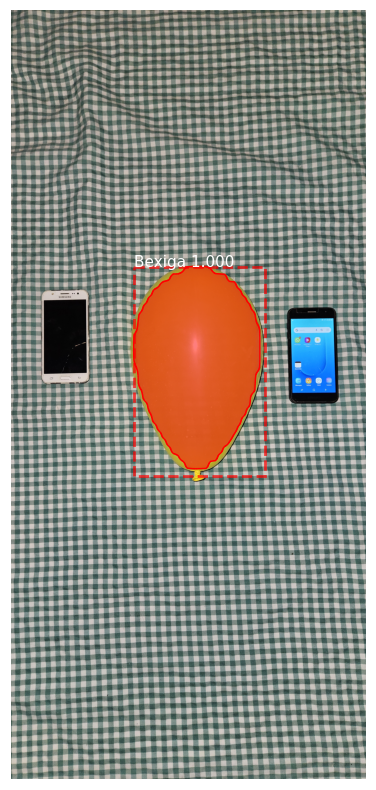

In [29]:
# Índice da imagem
indice = 1

# Define o objeto que será segmentado
# tipo_modelo: 'balloon', 'phone' ou 'balloon_phone'
tipo = "balloon"

# Define se a imagem original (sem segmentações) será apresentada
APRESENTAR_IMAGEM_ORIGINAL = False

# Define se a imagem gerada (com a segmentação) será apresentada
APRESENTAR_IMAGEM_SEGMENTADA = True

#===============================================================================

if df_imagens.shape[0] > indice:

  # Define a imagem com base em seu caminho
  img_teste = imread(df_imagens.loc[indice, 'caminho'])
  # img_teste = imread("imagem.png") # Você pode acrescentar um caminho qualquer de uma imagem, caso não queira usar as do dataframe

  if APRESENTAR_IMAGEM_ORIGINAL:

    # Mostra a imagem original
    mostrar(img_teste)

  # Apresenta a imagem com a segmentação
  r = segmentar_imagem(model = modelo_classe[tipo][0], img = img_teste, tipo_modelo = modelo_classe[tipo][1], visualizar = APRESENTAR_IMAGEM_SEGMENTADA)

# Avisa ao usuário o índice máximo permitido
else: print(f"O índice deve ser menor ou igual a {df_imagens.shape[0] - 1}")

In [38]:
pol = np.poly1d([-2.91305676e-05,  2.73060713e-02,  1.29845977e+00,  8.18736282e+01])

print(pol)

            3           2
-2.913e-05 x + 0.02731 x + 1.298 x + 81.87


### 7.2. Gera uma imagem com o efeito Cut Out

In [ ]:
def gerar_imagem_segmentada_balao_celular(image_path: str, output_path: str):

    """
    Gera uma imagem em escala de cinza, com o balão e o celular com cores diferentes para destacar a segmentação do modelo.

    Args:
        image_path (str): Caminho da imagem que será segmentada. 
        output_path (str): Caminho da imagem já segmentada.
    """

    # Dicionário que conterá o modelo e o nome das classes para a segmentação
    modelo_classe = {'balloon': (model_balloon, ['Bexiga']), 
                    'phone': (model_phone, ["Celular"]), 
                    'balloon_phone': (model_balloon_phone, ['Bexiga', 'Celular'])}
    
    # Define os objetos que serão segmentados
    lista_objetos = ["balloon", "phone"]

    # Lista que conterá a máscara de segmentação de todos os objetos que forem passados
    lista_mascara_segmentacao = []

    # Passa por todo objeto para fazer a segmentação de cada um
    for objeto in lista_objetos:

        # Obtém a máscara de segmentação do objeto
        r = segmentar_imagem(model = modelo_classe[objeto][0], 
                            img = imread(image_path), 
                            tipo_modelo = modelo_classe[objeto][1], 
                            visualizar = False)
        
        # Salva a máscara de segmentação na lista
        lista_mascara_segmentacao.append(r)

    # Aplica a máscara de segmentação na imagem e salva a nova imagem
    highlight_objects(image_path = image_path, 
                    class1 = lista_mascara_segmentacao[1], 
                    class2 = lista_mascara_segmentacao[0], 
                    output_path = output_path, 
                    alpha = 1, 
                    intensity = 0.0)

O usuário pode definir o caminho da imagem tanto pelo dataframe quanto por outro caminho da imagem

In [ ]:
# Índice do dataframe
indice = 3

# Caminho da imagem de entrada (imagem que será segmentada)
image_path = df_imagens["caminho"][indice].split("future_alaatus\\")[1]

# Imagem de saída (com a aplicação da máscara de segmentação)
output_path = "imagens_geradas/imagem_cut_out.png"

gerar_imagem_segmentada_balao_celular(image_path = image_path, output_path = output_path)

### 7.3. Realiza a segmentação para todas as imagens com todos os objetos e gera um dataframe com os respectivos dados

In [33]:
# Lista que armazenará a quantidade de segmentações, e a média de pixels dos objetos segmentados
lista_resultados = []

lista_info = []

# Registra a chave da imagem
indice = 0

# Percorre todas as imagens
for indice in tqdm(range(df_imagens.shape[0])):

    lista_objetos = []

    for tipo in ["balloon", "phone"]:

        # Seleciona o modelo que realizará a segumentação
        model = modelo_classe[tipo][0]
    
        # Seleciona a linha do dataframe referente ao seu índice
        df_imagem_especifica = df_imagens.iloc[indice]

        # Define a imagem
        img = imread(df_imagem_especifica['caminho'])

        # Obtém os resultados da semgentação
        resultados = model.detect([img], verbose=0)
        r = resultados[0]

        # Apresenta quantos objetos o modelo conseguiu segmentar
        quantidade_segmentações = r['masks'].shape[2]

        # Caso tenha sido detectado pelo menos um objeto, obtém a quantidade média de pixels de todas as segmentações
        if quantidade_segmentações != 0: media_pixels = r['masks'].sum() / quantidade_segmentações

        # Caso nenhum objeto tenha sido detectado
        else: media_pixels = 0

        # Armazenará na lista a quantidade de segmentações e média de pixels respectivamente de cada objeto
        lista_objetos.append((quantidade_segmentações, media_pixels))
        
    # Armazena: Índice da imagem, peso do balão (gramas), a quantidade de segmentações e a média de pixels dos objetos segmentados
    lista_resultados.append(lista_objetos)
    lista_info.append((df_imagens.iloc[indice]["caminho"], df_imagens.iloc[indice]["imagem"], df_imagens.iloc[indice]["id"], df_imagens.iloc[indice]["gramas"]))

    indice += 1

100%|██████████| 177/177 [21:29<00:00,  7.29s/it]


Organizando os dados das listas

In [35]:
# Deixa no final uma lista de listas de 4 elementos 
# (Quantidade de segmentações da bexiga, média de pixels da bexiga, Quantidade de segmentações do celular, média de pixels do celular)
lista_final = []
for linha in lista_resultados:
    lista_tuplas = []
    for tupla in linha:
        lista_tuplas.extend(tupla)
    lista_final.append(tuple(lista_tuplas))

# Junta a lista que contém a quantidade e a média de pixels de cada um dos objetos, e as informações de localização da imagem, id, gramas
lista_final_info = list(zip(lista_final, lista_info))

# Deixa no final uma lista de listas de 4 elementos 
# (Quantidade de segmentações da bexiga, média de pixels da bexiga, Quantidade de segmentações do celular, média de pixels do celular)
lista_final = []
for linha in lista_final_info:
    lista_tuplas = []
    for tupla in linha:
        lista_tuplas.extend(tupla)
    lista_final.append(tuple(lista_tuplas))

Construindo o dataframe

In [36]:
# Define o nome das colunas
nome_colunas = ["segmentacoes_bexiga", "media_pixels_bexiga",
                "segmentacoes_celular", "media_pixels_celular",
                "caminho_imagem", "nome_imagem", "id", "peso_gramas"]

# Cria o dataframe
df = pd.DataFrame(data = lista_final, columns = nome_colunas)

# Altera a ordem das colunas
df = df[['caminho_imagem', 'nome_imagem', 'id', 'peso_gramas', 'segmentacoes_bexiga', 'media_pixels_bexiga', 'segmentacoes_celular', 'media_pixels_celular']]

# Os dois celulares possuem a mesma dimensão
cm2_do_celular = 102.72

# Cria uma coluna para definir a quantidade de pixels por cm2
df["cm2_pixel"] = df["media_pixels_celular"] / cm2_do_celular

# Obtém o cm2 do balão
df["cm2_balao"] = df["media_pixels_bexiga"] / df["cm2_pixel"]

# Remove ac oluna "cm2_pixel", que agora é irrelevante para as análises
df.drop(columns = "cm2_pixel", inplace = True)

# Apresenta o dataframe
display(df.round(decimals = 2))

,caminho_imagem,nome_imagem,id,peso_gramas,segmentacoes_bexiga,media_pixels_bexiga,segmentacoes_celular,media_pixels_celular,cm2_balao
0,c:\Users\AriosvaldoBarros\Desktop\future_alaat...,20241201_161426.jpg,1,114,1,123911.0,0,0.0,inf
1,c:\Users\AriosvaldoBarros\Desktop\future_alaat...,20241201_161443.jpg,1,114,0,0.0,2,685152.5,0.00
2,c:\Users\AriosvaldoBarros\Desktop\future_alaat...,20241201_161447.jpg,1,114,1,552731.0,2,1085481.0,52.31
3,c:\Users\AriosvaldoBarros\Desktop\future_alaat...,20241201_161458.jpg,1,114,1,1277467.0,2,2492461.0,52.65
4,c:\Users\AriosvaldoBarros\Desktop\future_alaat...,20241201_161528.jpg,1,114,1,132268.0,0,0.0,inf
...,...,...,...,...,...,...,...,...,...
172,c:\Users\AriosvaldoBarros\Desktop\future_alaat...,20250518_204949.jpg,34,3948,1,828958.0,1,207511.0,410.34
173,c:\Users\AriosvaldoBarros\Desktop\future_alaat...,20250518_204954.jpg,34,3948,1,2123456.0,1,487440.0,447.48
174,c:\Users\AriosvaldoBarros\Desktop\future_alaat...,20250518_204959.jpg,34,3948,1,3285507.0,0,0.0,inf
175,c:\Users\AriosvaldoBarros\Desktop\future_alaat...,20250518_205006.jpg,34,3948,1,4354586.0,1,810026.0,552.21


In [ ]:
# Salva o dataframe
df.to_parquet("analise_dados/dados_balao.parquet", engine = "pyarrow")